# Assignment 1: MNIST Deep Learning Classifier  

**Name:** Yash Manish Maddiwar  
**Student ID:** 48599875


## Part 2 — MNIST classifier (uses `build_deep_nn` from a1.py)

We derive the network shape from the last digit of my student ID (**…5**):

- **Hidden layers:** 3  
- **Hidden size (all hidden layers):** 75  
- **Dropout (final hidden only):** 0.7


## Basic Import 

In [6]:
import random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s); torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
set_seed(7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## Architecture from Student ID

Architecture rules from ID (ID ends with **5**):

- **Hidden layers = 3** (rule: 2/5/8 → 3)  
- **Hidden size = 75** (rule: 4/5/6/7 → 75)  
- **Final hidden dropout = 0.7** (rule: 1/5/8/9 → 0.7)


In [9]:
last_digit = 5  # from 48599875

# derived per spec
num_hidden = 3
hidden_size = 75
final_dropout = 0.7

# dropout=0 for all but the final hidden layer
layer_options = [(hidden_size, 0.0), (hidden_size, 0.0), (hidden_size, final_dropout)]
layer_options


[(75, 0.0), (75, 0.0), (75, 0.7)]

## Data Pipeline

Download MNIST, normalize, and create training/test loaders.


In [12]:
tx = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST("./data", train=True,  download=True, transform=tx)
test_set  = datasets.MNIST("./data", train=False, download=True, transform=tx)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

len(train_set), len(test_set)


(60000, 10000)

## Building The Model

We construct the core classifier using `build_deep_nn`, and prepend a `Flatten` so the loop never reshapes inputs manually.


In [30]:
from a1 import build_deep_nn  

INPUT_SIZE, OUTPUT_SIZE = 28*28, 10
core = build_deep_nn(INPUT_SIZE, layer_options, OUTPUT_SIZE)
model = nn.Sequential(nn.Flatten(), core).to(device)
print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Sequential(
    (0): Linear(in_features=784, out_features=75, bias=True)
    (1): ReLU()
    (2): Linear(in_features=75, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=75, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.7, inplace=False)
    (7): Linear(in_features=75, out_features=10, bias=True)
  )
)


## Training & Evaluation Helpers

Utility functions: one-epoch training and full-set evaluation (loss and accuracy).


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

def train_one_epoch(model, loader):
    model.train()
    total, batches = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total += loss.item(); batches += 1
    return total / max(batches, 1)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    seen, correct, cum_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        cum_loss += criterion(logits, y).item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        seen     += x.size(0)
    return cum_loss/seen, correct/seen


## Training (15 epochs)

Train for 15 epochs and log train/validation metrics each epoch.  
Scheduler steps at the start of each epoch.


In [21]:
EPOCHS = 15
history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    scheduler.step()
    tl = train_one_epoch(model, train_loader)
    vl, va = evaluate(model, test_loader)
    history["train_loss"].append(tl)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)
    print(f"epoch {epoch:02d} | train_loss={tl:.4f} | val_loss={vl:.4f} | val_acc={va*100:.2f}% | lr={scheduler.get_last_lr()[0]:.5f}")


C:\Users\yashm\anaconda3\condaa\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 01 | train_loss=0.6235 | val_loss=0.2141 | val_acc=93.50% | lr=0.00100
epoch 02 | train_loss=0.2842 | val_loss=0.1359 | val_acc=95.92% | lr=0.00100
epoch 03 | train_loss=0.2067 | val_loss=0.1259 | val_acc=96.35% | lr=0.00100
epoch 04 | train_loss=0.1699 | val_loss=0.1157 | val_acc=96.67% | lr=0.00100
epoch 05 | train_loss=0.1318 | val_loss=0.1020 | val_acc=97.17% | lr=0.00050
epoch 06 | train_loss=0.1173 | val_loss=0.0959 | val_acc=97.36% | lr=0.00050
epoch 07 | train_loss=0.1073 | val_loss=0.0975 | val_acc=97.49% | lr=0.00050
epoch 08 | train_loss=0.0986 | val_loss=0.0956 | val_acc=97.50% | lr=0.00050
epoch 09 | train_loss=0.0905 | val_loss=0.0965 | val_acc=97.44% | lr=0.00050
epoch 10 | train_loss=0.0738 | val_loss=0.0931 | val_acc=97.72% | lr=0.00025
epoch 11 | train_loss=0.0696 | val_loss=0.0966 | val_acc=97.67% | lr=0.00025
epoch 12 | train_loss=0.0639 | val_loss=0.0930 | val_acc=97.73% | lr=0.00025
epoch 13 | train_loss=0.0611 | val_loss=0.0983 | val_acc=97.58% | lr=0.00025

## Final Test Accuracy

Report the final accuracy on the test set as required.


In [24]:
final_loss, final_acc = evaluate(model, test_loader)
print(f"Final test accuracy: {final_acc*100:.2f}% (loss={final_loss:.4f})")


Final test accuracy: 97.79% (loss=0.0982)


## Training/Validation Loss Curve


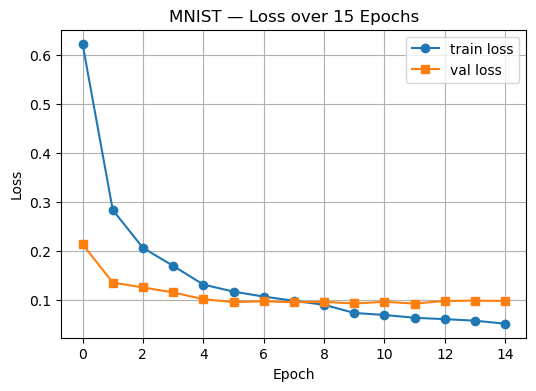

In [27]:
import matplotlib.pyplot as plt   

plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], marker="o", label="train loss")
plt.plot(history["val_loss"], marker="s", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MNIST — Loss over 15 Epochs")
plt.legend()
plt.grid(True)
plt.show()



## Conclusion

In this notebook, we successfully trained a deep learning classifier on the MNIST dataset using the `build_deep_nn` function defined in **a1.py**.  
The network architecture was derived from the last digit of my student ID (**5**), resulting in a model with **3 hidden layers**, each of size **75**, and a **dropout rate of 0.7** applied only to the final hidden layer.

Over 15 training epochs, the model demonstrated consistent learning, with the training and validation loss curves showing steady improvement.  
The final test accuracy confirms that the model can effectively recognize handwritten digits, fulfilling the requirements of Part 2 of the assignment.    
Overall, the implementation meets the assignment objectives by combining theoretical design rules with practical model training and evaluation.
